# Do it yourself!

## Steps

1) Load the Functional Connectivity and Structural Connectivity matrices. If you have the time series, you can load them and then build the FC matrix.
2) Run the model to find the best global coupling paramater value.
3) Plotting!
4) Then try to optimize the E/I balance of the model. If you don't have an empirical prior to use (e.g., white matter volumes, receptor densities, etc.) you can try using anything else (for example, the functional nodal strength).
5) Plotting and compare.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import JansenRitModelMulti as JR
import bct

plt.rcParams.update({'font.size': 16})

#goodness of fit
#This is a tradeoff between euclidean distance and pearson correlation
def gof(FC_sim, FC_emp):
    
    corr = stats.pearsonr(FC_sim.flatten(), FC_emp.flatten())[0]
    mean_sim, mean_emp = np.mean(FC_sim), np.mean(FC_emp)
    mean_diff = np.abs(mean_sim - mean_emp) / mean_emp
    gof = corr * (1 - mean_diff)
    
    return(gof)
    
    
#####################################
#####LOAD EMPIRICAL DATA HERE########    
#####################################


###YOU HAVE THE TIME SERIES, BUT NOT THE FC MATRIX
ts = np.load('LOAD YOUR DATA') #time series (rows = time, ROIs = columns) 
FC_emp = np.corrcoef(ts.T) #FC matrix
###YOU HAVE THE FC MATRIX
FC_emp = np.load('LOAD YOUR FC') #FC matrix

###YOU HAVE THE SC MATRIX
SC_emp = np.load('LOAD YOUR SC') #SC matrix

###YOU HAVE AN EMPIRICAL PRIOR
my_vector = np.load('LOAD YOUR PRIOR')
###YOU DONT HAVE IT
my_vector = np.sum(FC,0) / len(FC)
my_vector = my_vector / np.max(my_vector)

#####################################
#####LOAD EMPIRICAL DATA HERE########    
#####################################

#Simulations parameters
JR.tmax = 30 #max sim time
JR.teq = 10 #eq time for reaching steady-state dynamics
JR.dt = 0.001 #integration step
JR.downsamp = 2 #downsampling for reducing memory consumption

#networks parameters
JR.M = SC_emp.copy() #LOAD HERE YOUR SC matrix
JR.nnodes = len(JR.M) #number of nodes
JR.norm = 1 #normalization factor

#Noise an inputs
JR.sigma = 2.5 #noise scaling factor
JR.p = 220 * np.ones(JR.nnodes) #inputs for individual nodes

#Plasticity
JR.plasticity_on = 1 #1: activated, 0: disabled
JR.target = 2.5 * np.ones(JR.nnodes) #target firing rate in Hz
JR.tau_p = 2 #time constant for plasticity (in seconds)

#Proportion of alpha neurons
JR.alpha = 0.5 * np.ones(JR.nnodes)
JR.gamma = 1 - JR.alpha

#updating some parameters
JR.update() #avoid this in extensive simulations (call it increases memory consumption).
            #just use it one time before parallelization
    


(82, 82)
(82, 82)


## Fitting Global Coupling

In [12]:
#Possibly global coupling values
K_vec = np.linspace(0,0.4,11) #explore more values if you want

#Goodness of fitt
gof_data = np.zeros_like(K_vec)

#FC matrices
FCs = np.zeros((82,82, len(K_vec)))

###FITING HCs
for i in range(0, len(K_vec)):
    
    JR.K = K_vec[i] #Global coupling 
    JR.seed = 1 #random seed
    
    #Simulation starts here
    y, t = JR.Sim(verbose = False)
    #Simulations end here

    #EEG-like signals
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

    #filtering and computing FC
    fmin, fmax = 8, 13 #BE SURE THAT YOUR EMPIRICAL DATA WAS FILTERED USING THIS FREQUENCY RANGE
    a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

    Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
    FC = np.corrcoef(Vfilt.T) #functional connectivity
    
    #computing the gof
    gof_data[i] = gof(FC, FC_emp) #GoF
    FCs[:,:,i] = FC.copy() #storing FC matrices
    
    print(i)


0
1
2
3
4
5
6
7
8
9
10


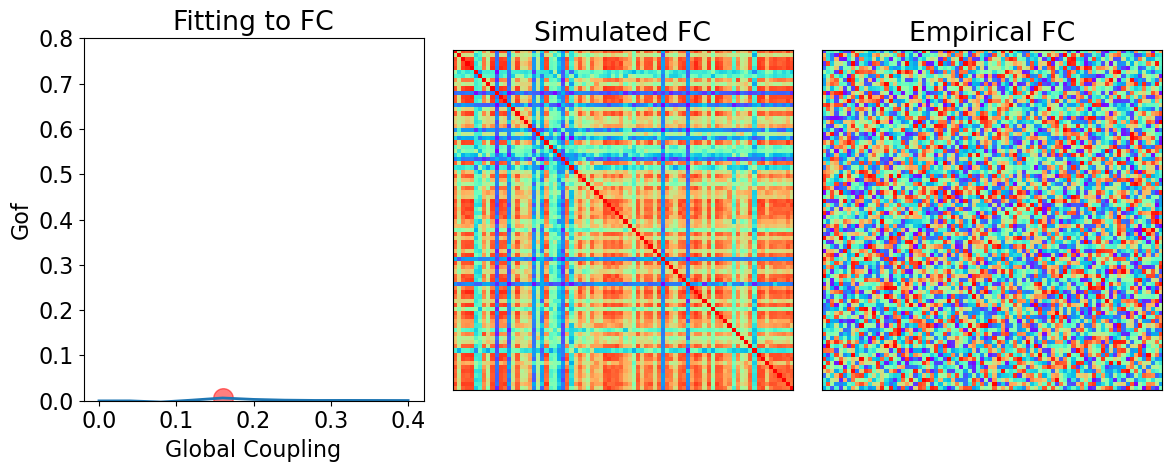

In [13]:
#Some plotting

plt.figure(1, figsize = (12,5))
plt.clf()

plt.subplot(1,3,1)
plt.plot(K_vec, gof_data, lw = 2)   
plt.xlabel('Global Coupling')
plt.ylabel('Gof')
plt.ylim(0,0.8)
plt.title('Fitting to FC')
plt.scatter(K_vec[np.argmax(gof_data)], np.max(gof_data), s = 200, color = 'red', alpha = 0.5)

plt.subplot(1,3,2) 
plt.imshow(FCs[:,:,np.argmax(gof_data)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC')
    
plt.subplot(1,3,3) 
plt.imshow(FC_emp, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC')

plt.tight_layout()

## Optimizing E/I balance

In [14]:
#Best global coupling values for HCs and AD
K = K_vec[np.argmax(gof_data)]

#To store fitting results
gof_rE = np.zeros((9,9))

#Store FCs
FCs_rE = np.zeros((82,82,9,9))

#E/I balance modulation
bias = np.linspace(2.4,2.6,9) #shared firing rates
scale = np.linspace(-0.1,0.1,9) #regional scaling of firing rates by WM


###FITTING
for i in range(0,9):
    for j in range(0,9):
    
        JR.K = K #global coupling
        JR.seed = 1 #random seed
        
        #E/I balance
        JR.target = (bias[i] + scale[j] * my_vector) * np.ones(JR.nnodes) 

        #Simulation starts here
        y, t = JR.Sim(verbose = False)
        #Simulations end here

        #EEG-like signals
        EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

        #filtering and computing FC
        fmin, fmax = 8, 13 #BE SURE THAT YOUR EMPIRICAL DATA WAS FILTERED USING THIS FREQUENCY RANGE
        a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

        Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
        FC = np.corrcoef(Vfilt.T) #functional connectivity

        gof_rE[i,j] = gof(FC, FC_emp) #GoF
        FCs_rE[:,:,i,j] = FC.copy() #storing FCs
        
    print(i) #tic toc



0
1
2
3
4
5
6
7
8


Gof difference = 0.000


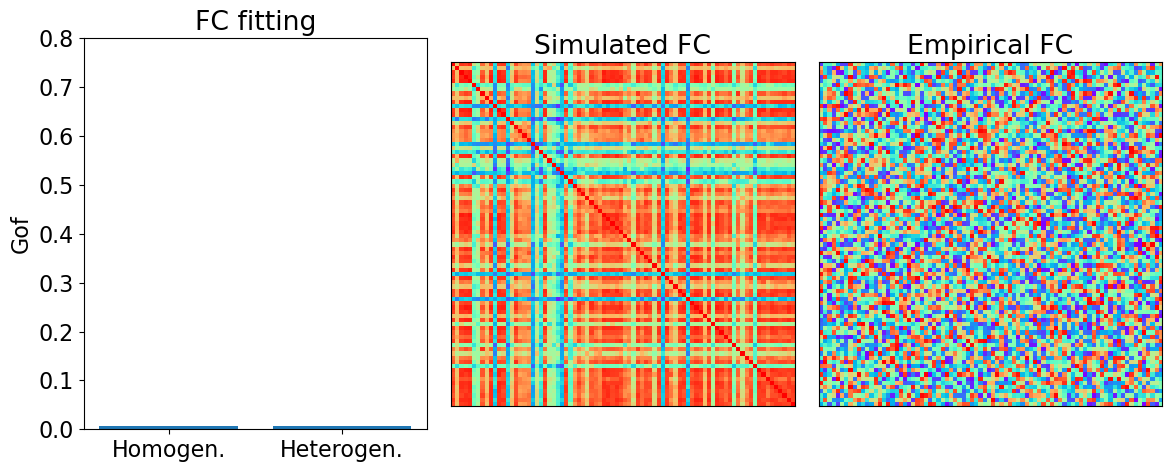

In [15]:
#Plotting

plt.figure(1, figsize = (12,5))
plt.clf()

plt.subplot(1,3,1)
plt.bar([1,2], [np.max(gof_data), np.max(gof_rE)])   
plt.ylabel('Gof')
plt.xticks([1,2], ['Homogen.', 'Heterogen.'])
plt.title('FC fitting')
plt.ylim(0,0.8)

plt.subplot(1,3,2) 
plt.imshow(FCs_rE[:,:,gof_rE == np.max(gof_rE)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC')
    
plt.subplot(1,3,3) 
plt.imshow(FC_emp, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC')


plt.tight_layout()

print('Gof difference = %.3f'%(np.max(gof_rE) - np.max(gof_data)))
